In [1]:
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Masking, Bidirectional, LSTM, TimeDistributed, Dense, Activation

2023-01-01 01:12:30.043765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-01 01:12:33.763432: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-01 01:12:33.763639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-01 01:12:33.763665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
BATCH_SIZE = 256
VALIDATION_RATIO = 0.1

PIECE_LEN = 1024
n_feature = 42
n_hidden = 200
n_pitch = 52
learning_rate = 0.001

## build dataset

In [3]:
def load_npy_data(x_path, y_path, offset):
    x = np.load(x_path)
    y = np.load(y_path)
    if x.shape[0] >= offset+PIECE_LEN:
        return x[offset:offset+PIECE_LEN].astype(np.float64), y[offset:offset+PIECE_LEN].astype(np.float64)
    else:
        pad_count = offset + PIECE_LEN - x.shape[0]
        x = np.pad(x[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        y = np.pad(y[offset:], ((0, pad_count), (0, 0)), 'constant', constant_values=-1).astype(np.float64)
        return x, y

def generate_dataset(input_dir: str):
    x_paths = []
    y_paths = []
    offsets = []
    for file_name in sorted(os.listdir(input_dir)):
        if file_name.endswith(".ans.npy"):
            y_path = str(os.path.join(input_dir, file_name))
            x_path = str(os.path.join(input_dir, file_name.replace(".ans.npy", ".npy")))
            assert os.path.exists(x_path), f"corresponding input file {x_path} doesn't exist"
            y_content = np.load(y_path)
            for offset in range(0, y_content.shape[0], PIECE_LEN):
                y_paths.append(y_path)
                x_paths.append(x_path)
                offsets.append(offset)

    
    train_dataset = tf.data.Dataset.from_tensor_slices((x_paths, y_paths, offsets)).shuffle(100000)
    train_dataset = train_dataset.map(lambda x_path, y_path, offset: tf.numpy_function(load_npy_data, [x_path, y_path, offset], [tf.float64, tf.float64]))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(-1).cache()
    
    return train_dataset

In [4]:
train_dataset = generate_dataset("preprocessed_dataset/irealpro_midi")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-01 01:13:23.560195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 01:13:23.582681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 01:13:23.583265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-01 01:13:23.584538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

## build model

In [5]:
# print("Creating model")
input = tf.keras.Input(shape=(PIECE_LEN, n_feature))  
x = Masking(mask_value=-1, input_shape=(PIECE_LEN, n_feature))(input) # Ignore Padded Data
x = Bidirectional(LSTM(units=n_hidden, input_shape=(1, n_feature), return_sequences=True))(x)
x = TimeDistributed(Dense(n_pitch, activation="softmax"))(x)
model = tf.keras.Model(inputs=input, outputs=x)

# model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#                 metrics=tf.keras.metrics.CategoricalAccuracy())
print(model.summary())

optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 42)]        0         
                                                                 
 masking (Masking)           (None, 1024, 42)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 1024, 400)        388800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1024, 52)         20852     
 ibuted)                                                         
                                                                 
Total params: 409,652
Trainable params: 409,652
Non-trainable params: 0
_________________________________________________________________
None


## loss/accuracy function

In [6]:
def masked_loss_function(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    loss = tf.losses.categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(y_true, y_pred):
    mask = tf.math.not_equal(tf.reduce_sum(y_true, axis=2), -1*n_pitch)
    acc = tf.metrics.categorical_accuracy(y_true, y_pred)
    mask = tf.cast(mask, acc.dtype)
    acc *= mask
    return tf.reduce_mean(acc)

### restore checkpoint

In [7]:
checkpoint_dir = './checkpoints/BDLSTM_Staged'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [ ]:
checkpoint.restore(checkpoint_prefix+"-2")

## training

### stage 1 - irealpro dataset

In [8]:
@tf.function
def train_step(x, y):
    loss = 0
    with tf.GradientTape() as tape:
        pred = model(x)
        
        loss = masked_loss_function(y, pred)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = masked_accuracy(y, pred)

    return loss, acc

In [9]:
# set the epochs for training
EPOCHS = 100
loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(total_loss / steps_per_epoch)

2023-01-01 01:14:16.033529: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_20/output/_23'
2023-01-01 01:14:16.394045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201
2023-01-01 01:14:16.759315: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f68ab2699f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-01 01:14:16.759357: I tensorflow/compiler/

Epoch 1 Loss 1.8535 Acc 0.2784
Time taken for 1 epoch 45.56416082382202 sec

Epoch 2 Loss 1.1180 Acc 0.4111
Time taken for 1 epoch 7.557880163192749 sec

Epoch 3 Loss 0.8918 Acc 0.4627
Time taken for 1 epoch 7.585672378540039 sec

Epoch 4 Loss 0.7720 Acc 0.4948
Time taken for 1 epoch 7.534012079238892 sec

Epoch 5 Loss 0.7116 Acc 0.5116
Time taken for 1 epoch 7.504323959350586 sec

Epoch 6 Loss 0.6729 Acc 0.5239
Time taken for 1 epoch 7.563030004501343 sec

Epoch 7 Loss 0.6411 Acc 0.5351
Time taken for 1 epoch 7.585261106491089 sec

Epoch 8 Loss 0.6163 Acc 0.5433
Time taken for 1 epoch 7.623305320739746 sec

Epoch 9 Loss 0.5967 Acc 0.5497
Time taken for 1 epoch 7.584662437438965 sec

Epoch 10 Loss 0.5808 Acc 0.5547
Time taken for 1 epoch 7.619035959243774 sec

Epoch 11 Loss 0.5669 Acc 0.5593
Time taken for 1 epoch 7.624865770339966 sec

Epoch 12 Loss 0.5563 Acc 0.5623
Time taken for 1 epoch 7.627853631973267 sec

Epoch 13 Loss 0.5448 Acc 0.5664
Time taken for 1 epoch 7.6446826457977295

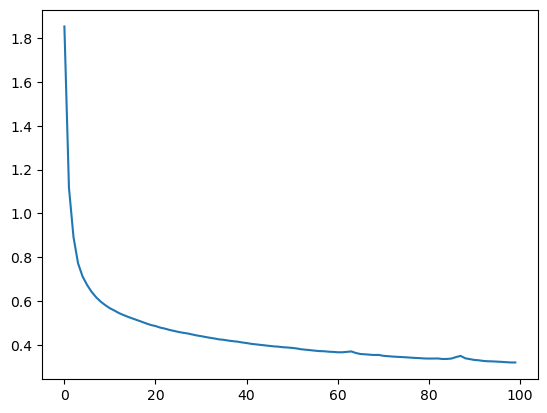

In [13]:
plt.plot(loss_history)
np.save("experiments/BDLSTM_Staged/history_stage1.npy", np.array(loss_history))

In [11]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/BDLSTM_Staged/ckpt-1'

### stage 2 dense dataset

In [12]:
del train_dataset
train_dataset = generate_dataset("preprocessed_dataset/dense_jazz")

In [14]:
# set the epochs for training
EPOCHS = 200
loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    # saving (checkpoint) the model every 2 epochs
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(total_loss / steps_per_epoch)

Epoch 1 Loss 1.7557 Acc 0.2728
Time taken for 1 epoch 62.060946464538574 sec

Epoch 2 Loss 1.5116 Acc 0.3022
Time taken for 1 epoch 11.739261150360107 sec

Epoch 3 Loss 1.4710 Acc 0.3110
Time taken for 1 epoch 11.733944654464722 sec

Epoch 4 Loss 1.4475 Acc 0.3169
Time taken for 1 epoch 11.737059116363525 sec

Epoch 5 Loss 1.4313 Acc 0.3203
Time taken for 1 epoch 11.760156631469727 sec

Epoch 6 Loss 1.4186 Acc 0.3231
Time taken for 1 epoch 11.8155357837677 sec

Epoch 7 Loss 1.4096 Acc 0.3254
Time taken for 1 epoch 11.83515214920044 sec

Epoch 8 Loss 1.4002 Acc 0.3276
Time taken for 1 epoch 11.830883026123047 sec

Epoch 9 Loss 1.3925 Acc 0.3294
Time taken for 1 epoch 11.877280950546265 sec

Epoch 10 Loss 1.3863 Acc 0.3308
Time taken for 1 epoch 11.870894432067871 sec

Epoch 11 Loss 1.3795 Acc 0.3321
Time taken for 1 epoch 11.883182764053345 sec

Epoch 12 Loss 1.3731 Acc 0.3342
Time taken for 1 epoch 11.894718408584595 sec

Epoch 13 Loss 1.3678 Acc 0.3355
Time taken for 1 epoch 11.947072

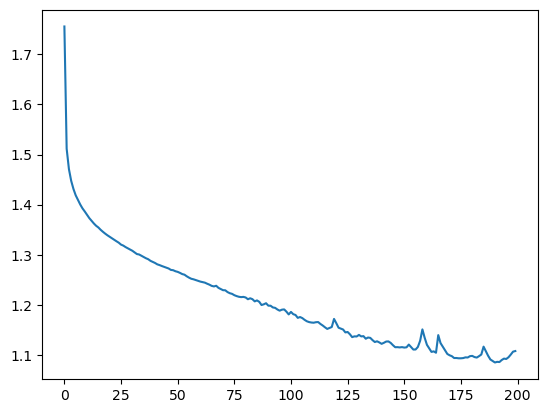

In [15]:
plt.plot(loss_history)
np.save("experiments/BDLSTM_Staged/history_stage2.npy", np.array(loss_history))

In [16]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/BDLSTM_Staged/ckpt-2'

### stage 3 - full dataset

In [17]:
del train_dataset
train_dataset = generate_dataset("preprocessed_dataset/augmentation")

In [18]:
EPOCHS = 200
loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    total_loss = 0
    total_acc = 0
    steps_per_epoch = 0

    for x, y in train_dataset:
        batch_loss, batch_acc = train_step(x, y)
        total_loss += batch_loss
        total_acc += batch_acc
        steps_per_epoch += 1
    
    print(f'Epoch {epoch+1} Loss {total_loss / steps_per_epoch:.4f} Acc {total_acc / steps_per_epoch:.4f}')
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    loss_history.append(total_loss / steps_per_epoch)

Epoch 1 Loss 1.3460 Acc 0.3365
Time taken for 1 epoch 138.1246976852417 sec

Epoch 2 Loss 1.3230 Acc 0.3412
Time taken for 1 epoch 21.49126672744751 sec

Epoch 3 Loss 1.3051 Acc 0.3468
Time taken for 1 epoch 21.512390851974487 sec

Epoch 4 Loss 1.2995 Acc 0.3480
Time taken for 1 epoch 21.666032791137695 sec

Epoch 5 Loss 1.2886 Acc 0.3515
Time taken for 1 epoch 21.539012908935547 sec

Epoch 6 Loss 1.2773 Acc 0.3550
Time taken for 1 epoch 21.695889949798584 sec

Epoch 7 Loss 1.2731 Acc 0.3565
Time taken for 1 epoch 21.84110999107361 sec

Epoch 8 Loss 1.2704 Acc 0.3571
Time taken for 1 epoch 21.9455783367157 sec

Epoch 9 Loss 1.2611 Acc 0.3602
Time taken for 1 epoch 21.91727900505066 sec

Epoch 10 Loss 1.2542 Acc 0.3624
Time taken for 1 epoch 21.86399531364441 sec

Epoch 11 Loss 1.2513 Acc 0.3632
Time taken for 1 epoch 21.897631883621216 sec

Epoch 12 Loss 1.2452 Acc 0.3652
Time taken for 1 epoch 22.052060842514038 sec

Epoch 13 Loss 1.2421 Acc 0.3661
Time taken for 1 epoch 22.0204489231

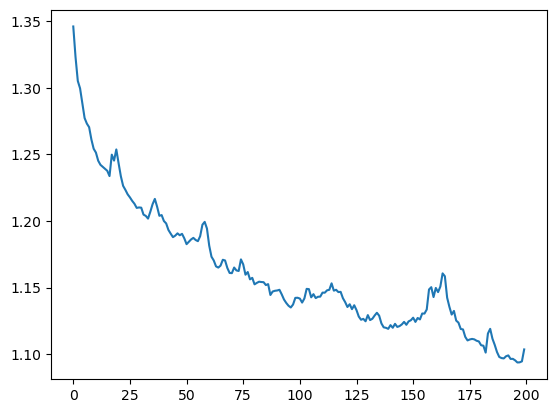

In [19]:
plt.plot(loss_history)
np.save("experiments/BDLSTM_Staged/history_stage3.npy", np.array(loss_history))

In [20]:
checkpoint.save(checkpoint_prefix)

'./checkpoints/BDLSTM_Staged/ckpt-3'

## predict

In [21]:
def slice_per_step(a, step=PIECE_LEN):
    # add -1 to the end of each sample to make them the same length per step(piece_length)
    pad_count = step - (a.shape[0] % step)
    # print(a.shape, end=' ')
    if pad_count!=step : 
        # print('pad by',pad_count, end=' ')
        a = np.pad(a, ((0, pad_count), (0, 0)), 'constant', constant_values=-1)
    # reshape into per step
    a = np.reshape(a, (-1, step, a.shape[1]))
    # print('to',a.shape)
    return a

In [22]:
import midi_np_translation.output2midi as output2midi

In [25]:
test_file = np.load("preprocessed_dataset/irealpro_midi/Autumn Leaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/irealpro_transposed/Autumn Leaves_o0.mid", 
                           output_path="experiments/BDLSTM_Staged/autumn_irealpro.mid")

1/1 [==============================] - 0s 35ms/step


In [26]:
test_file = np.load("preprocessed_dataset/dense_jazz/AutumnLeaves_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/AutumnLeaves_o0.mid", 
                           output_path="experiments/BDLSTM_Staged/autumn_arr.mid")

1/1 [==============================] - 0s 35ms/step


In [27]:
test_file = np.load("preprocessed_dataset/dense_jazz/PieceOfMyWish_p1.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/PieceOfMyWish_p1.mid", 
                           output_path="experiments/BDLSTM_Staged/PieceOfMyWish.mid")

1/1 [==============================] - 0s 35ms/step


In [28]:
test_file = np.load("preprocessed_dataset/augmentation/55Dive_o0.mid.npy")
test_result = model.predict(slice_per_step(test_file))
output2midi.output_to_midi(bass_ndarr=test_result.reshape(-1,52), 
                           ref_midi_path="input_midi/transpose_augmentation/55Dive_o0.mid", 
                           output_path="experiments/BDLSTM_Staged/55Dive.mid")

1/1 [==============================] - 0s 49ms/step
